In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# PyGMQL in action

## Problem description
We are given three replicas of a ChIP-Seq experiment.
We want to:
1. Extract **high-confidence regions** into one sample
2. Identify which of these regions **overlap** with a set of given genes
3. For each resulting region count ICGC **mutations**.
4. Finally we want to select the regions with **at least one** mutation.

## Required GMQL operations
For this pipeline we will need the following GMQL operations:
- ```cover```: extracts regions which are confirmed by at least two replicas
- ```join```: extracts regions which overalap with genes
- ```map```: for each extracted region, counts the overlapping mutations

## PyGMQL in a nutshell

PyGMQL enables the writing of GMQL queries using the Python programming language. It exposes to the user all the GMQL operators and also a data structure for holding, manipulating and converting the results of a GMQL query.

The library offers:
- A data structure called ```GMQLDataset```, which represent a GMQL variable in the query. Every GMQLDataset is produced by a GMQL operator. When you call the ```materialize``` operation on a GMQLDataset the execution is started and the result is returned.
- A data structure called ```GDataframe```, holding the result of a query. A GDataframe is a pure python structure and can be used directly as any other pandas dataframe. A GDataframe holds two pandas dataframes, one for the regions and one for the metadata. We can also, given a GDataframe, go back to a GMQLDataset for using it as a GMQL variable. This can be done calling the ```to_GMQLDataset``` function of the GDataframe.

<img src="./images/GMQLDataset_to_GDataframe.png" width="500" height="600">

### Getting the library

The library can be downloaded from the PyPi public repository through the ```pip``` packaging system.

```
    pip install gmql
```

If you want the most recent version of the software you can directly download it from the GitHub page:

```
    git pull https://github.com/DEIB-GECO/PyGMQL.git
    cd PyGMQL
    pip install -e .
```

### Importing the library

In [2]:
import gmql as gl
import pandas as pd

### Execution modes
The queries are directly embedded inside the language and can be executed in two different modes:
- __Local mode__: the computation is executed in the local machine
- __Remote mode__: the query is sent to a remote server, executed there and the results are downloaded. This process is shown in the figure below.

<img src="./images/remote.png">



##           <center>    <a href="http://www.gmql.eu/gmql-rest/swagger">GMQL Rest Interface</a> </center>

In [3]:
gl.set_mode("local")
gl.set_progress(True)

## The query

The GMQL query that we are going to present is the following:

```
refSeqGenes  = SELECT(annotation_type == 'gene' AND provider == 'RefSeq') HG19_BED_ANNOTATION;

myExp  = SELECT() myRawExp;
myConfirmExp  = COVER(2, ANY) myExp;

myExpOverGenes  = JOIN(DIST < 0; output: RIGHT_DISTINCT) refSeqGenes myConfirmExp;

myMut  = SELECT() myRawMut;
myMutOverExp = MAP() myExpOverGenes myMut;

myFilteredExp = SELECT(region: count_myMutOverExp_myMut > 0) myMutOverExp;

MATERIALIZE myFilteredExp INTO ./Results/FilteredExperiment
    
```

## Loading a GMQL dataset

### Loading datasets in GDM format

Both the gene dataset and the personal one are already in the GDM format, therefore the library only needs the location of the data for importing.

*NB: This demo is meant to be executed without the need of a remote server. For this reason the HG19_BED_ANNOTATION dataset is loaded directly from the computer disk. Please be aware that it can also be found in the regular GMQL repository.*

In [4]:
bed_annotation = gl.load_from_path("../data/demo/HG19_BED_ANNOTATION/")

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.37it/s]


In [5]:
myExp = gl.load_from_path("../data/demo/UPLOADED/")

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


### Loading datasets with a generic schema

The mutation dataset is in a classical BED format but not in the GDM format, therefore we need to specify its schema through a **custom parser**, which is an instance of a ```RegionParser```. 
After the parser is instantiated we can use the ```load_from_path``` function to load the dataset, which is currently stored in the local file system

In [6]:
mutations_parser = gl.parsers.RegionParser(parser_name="mutations_parser",
                                           chrPos=0,
                                           startPos=1,
                                           stopPos=2,
                                           otherPos=[
                                               (3, 'original_allele', "char"),
                                               (4, 'mutation_allele', "char")],
                                           delimiter="\t")

In [7]:
myMut = gl.load_from_path("../data/demo/ICGC_REPOSITORY/", parser=mutations_parser)


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.41it/s]


Also conversion from Pandas dataframe to GMQLDataset is possible using the ```from_pandas``` operation.

## Selection on the metadata

We have in the variable ```bed_annotation``` all the ENCODE dataset of annotations. We are interested only in the annotations regarding the genes. Therefore we need to *filter* the dataset **on the basis of the metadata**.
This is called ```meta-selection``` and in PyGMQL can be performed using the square-bracket notation common to pandas users.

In [8]:
refSeqGenes = bed_annotation[(bed_annotation['annotation_type'] == 'gene') & 
                             (bed_annotation['provider'] == 'RefSeq')]

## Cover operation
We want only reliable data from the Chip-Seq experiment, therefore we define a Chip-Seq region *highly confident* if it is confirmed by at least two replicas. This is a job for the ```cover``` operation.

- ```minAcc```: we define the minimum number of overlapping between samples for a region to be conserved. In this case 2.
- ```maxAcc```: we define the maximum number. The ```"ANY"``` keyword makes the upper bound infinite.

<img src="./images/cover.PNG">

In [9]:
myConfirmExp = myExp.normal_cover(minAcc=2, maxAcc="ANY")

## Join
Now we want to extract those regions that overlap with genes. We can do it using the ```join``` operation. 
- We use the genes as reference dataset
- The Chip-Seq regions as experiment. 
- The genometric predicate ```DLE(0)``` and the option ```output="RIGHT"``` tell the engine to look at all the experiment regions that happen to intersect with the reference ones and keep them in the result.

<img src="./images/join.PNG" height="700" width="700">

In [10]:
myExpOverGenes = refSeqGenes.join(experiment=myConfirmExp, refName="gene",
                                  genometric_predicate=[gl.DLE(0)],
                                  output="RIGHT_DISTINCT")

## Map
Now in ```insideGene``` we have the set of highly confident Chip-Seq regions that intersect with a gene. In order to see how many mutations happen in those region we can use the ```map``` operation. This operation will add a new attribute to the resulting dataset which will be named ```count_GENE_MUTATION```.

<img src="./images/map.PNG">

In [11]:
myMutOverExp = myExpOverGenes.map(myMut, expName="MUTATION", refName="GENE")

## Selection on regions
In order to filter out all the regions in ```mutationCount``` that do not have any mutation we can do a selection on region data using the ```reg_select``` operation. This operation takes as input a predicate on region fields.

In [12]:
myFilteredExp = myMutOverExp.reg_select(myMutOverExp.count_GENE_MUTATION > 0)

## Materialization
We can now materialize the result. PyGMQL adopts a *lazy loading* approach (like Spark) and no action is performed until materialization. The result can be saved as a GDM dataset and also directly loaded in python as a ```GDataframe```.

In [13]:
result = myFilteredExp.materialize()

100%|███████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 395.62it/s]


## The GDataframe
The result of a materialization is a ```GDataframe``` which contains both regions and metadata as two Pandas dataframes ```regs``` and ```meta```

In [14]:
# result.regs.sort_values(by='start').head()
result.regs.head()

,chr,start,stop,strand,AccIndex,JaccardIntersect,JaccardResult,count_GENE_MUTATION
id_sample,,,,,,,,
6829036658103970262,chr1,956167,957032,*,2,0.521713,0.521713,22.0
7322553018295201991,chr1,202204798,202205916,*,3,0.949066,0.390492,5.0
8655783753907876868,chr1,202204798,202205916,*,3,0.949066,0.390492,1.0
397924161598878532,chr1,3427054,3427635,*,2,0.401798,0.401798,6.0
6829036658103970262,chr1,202204798,202205916,*,3,0.949066,0.390492,7.0


In [15]:
print('\x1b[1;34m', 'Number of regions and columns: ', '\x1b[0m', result.regs.shape)
print('\x1b[1;34m', "Number of samples:", '\x1b[0m', len(set(result.regs.index)))

 Number of regions and columns:   (108, 8)
 Number of samples:  12


The region dataframe represents the regions in the output result in a tabular format. The index of the regions is the identifier of the sample they belong to.

In [16]:
result.meta[["GENE.HM_TF.type","GENE.DNAse.cell","MUTATION.disease"
             ,"MUTATION.type"]].head(3)

,GENE.HM_TF.type,GENE.DNAse.cell,MUTATION.disease,MUTATION.type
id_sample,,,,
-8887459254116471869,[broadPeak],[ECC-1],[Breast cancer],[single_base_substitution]
-4655530052381220435,[broadPeak],[ECC-1],[Thyroid cancer],[single_base_substitution]
-2300686516048319133,[broadPeak],[ECC-1],[Pancreatic cancer],[single_base_substitution]


The metadata dataframe has as columns all the metadata attributes and every row represents a sample in the output dataset. 

There can be multiple values in the same cell.

## Additional operations

Display the mean and median:

In [17]:
result.regs.columns

Index(['chr', 'start', 'stop', 'strand', 'AccIndex', 'JaccardIntersect',
       'JaccardResult', 'count_GENE_MUTATION'],
      dtype='object')

In [18]:
mean = result.regs['count_GENE_MUTATION'].mean()
print('\x1b[1;34m', 'mean:   ', '\x1b[0m', mean)
median = result.regs['count_GENE_MUTATION'].median()
print('\x1b[1;34m', 'median: ', '\x1b[0m', median)
# result.regs[result.regs['count_gene_mutation'] > 15]

 mean:     4.87037037037037
 median:   4.0



Having the result in a Pandas dataframe enables us to use all the Pandas functions and perform some statistics.

For example we can do an histogram of the mutation counts over the Chip-Seq regions showing the distribution of the number of mutations over those regions.

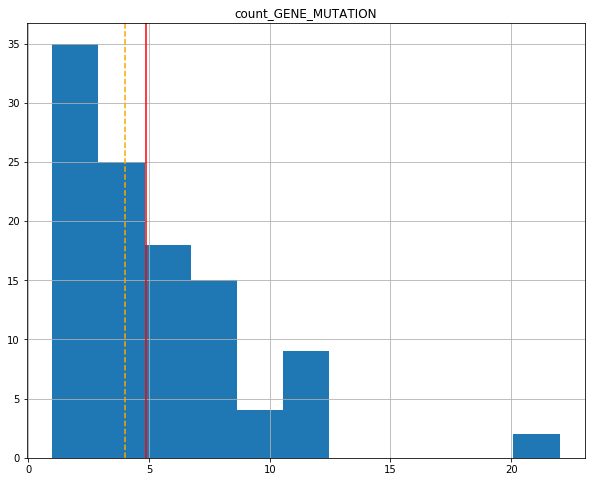

In [19]:
# draw all
result.regs.hist("count_GENE_MUTATION", bins=int(result.regs['count_GENE_MUTATION'].max()/2),figsize=(10,8))
plt.axvline(x=mean, color='red', linestyle='-')
plt.axvline(x=median, color='orange', linestyle='--')

## Alternative experiment
Mapping the mutations over the genes instead that over the experiment regions


The GMQL query that we are going to present is the following:


>    refSeqGenes  = SELECT(annotation_type == 'gene' AND provider == 'RefSeq') HG19_BED_ANNOTATION;
>
>    myExp  = SELECT() myRawExp;
>    myConfirmExp  = COVER(2, ANY) myExp;
>
>    myExpOverGenes  = JOIN(DIST < 0; output: <font color=blue>__LEFT_DISTINCT__</font>) refSeqGenes myConfirmExp;
>
>    myMut  = SELECT() myRawMut;
>    myMutOverExp = MAP() myExpOverGenes myMut;
>
>    myFilteredExp = SELECT(region: count_myMutOverExp_myMut > 0) myMutOverExp;
>
>    MATERIALIZE myFilteredExp INTO ./Results/FilteredExperiment


In [20]:
genesOverExp = refSeqGenes.join(experiment=myConfirmExp, refName="gene",
                                  genometric_predicate=[gl.DLE(0)],
                                  output="LEFT_DISTINCT")
myMutOverGenes = genesOverExp.map(myMut, expName="MUTATION", refName="GENE")
myFilteredGenes = myMutOverGenes.reg_select(myMutOverGenes.count_GENE_MUTATION > 0)
result_genes = myFilteredGenes.materialize()

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 498.66it/s]


In [21]:
result_genes.regs.head()

,chr,start,stop,strand,name,score,count_GENE_MUTATION
id_sample,,,,,,,
-1231030816949422728,chr1,42642209,42800636,-,NM_001198851,0.0,3.0
6829036658103970262,chr1,10270763,10368655,+,NM_183416,0.0,28.0
-1451580578250723319,chr1,167905796,168045083,+,NM_001198957,0.0,2.0
-8887459254116471869,chr1,41157241,41237275,+,NM_001142587,0.0,38.0
5977003163326493845,chr1,113009162,113063910,+,NM_004185,0.0,1.0


In [22]:
print('\x1b[1;34m', 'Number of regions and columns: ', '\x1b[0m', result_genes.regs.shape)
print('\x1b[1;34m', 'Number of samples:', '\x1b[0m', len(set(result_genes.regs.index)))

 Number of regions and columns:   (7307, 7)
 Number of samples:  12


In [23]:
mean = result_genes.regs['count_GENE_MUTATION'].mean()
print('\x1b[1;34m', 'mean:     ', '\x1b[0m', mean)
median = result_genes.regs['count_GENE_MUTATION'].median()
print('\x1b[1;34m', 'median:   ', '\x1b[0m', median)

 mean:       11.543998905159436
 median:     7.0


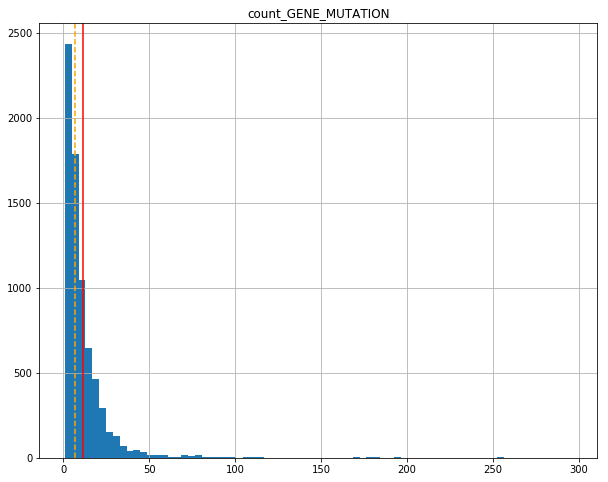

In [24]:
# draw all
result_genes.regs.hist("count_GENE_MUTATION", bins=int(result_genes.regs['count_GENE_MUTATION'].max()/4),figsize=(10,8))
plt.axvline(x=mean, color='red', linestyle='-')
plt.axvline(x=median, color='orange', linestyle='--')

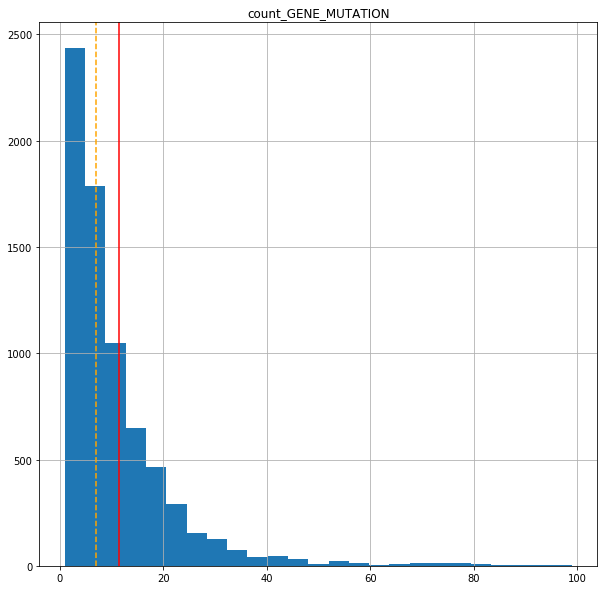

In [25]:
# draw less than 50
threshold = 100
result_genes.regs[result_genes.regs.count_GENE_MUTATION <=threshold].hist("count_GENE_MUTATION", bins=int(threshold/4),figsize=(10,10))
plt.axvline(x=mean, color='red', linestyle='-')
plt.axvline(x=median, color='orange', linestyle='--')

In [26]:
morethan = result_genes.regs[result_genes.regs.count_GENE_MUTATION > threshold].sort_values("count_GENE_MUTATION", ascending=False)
print('\x1b[1;34m', 'Number of regions less than threshold', '\x1b[0m', len(morethan))
morethan

 Number of regions less than threshold  44


,chr,start,stop,strand,name,score,count_GENE_MUTATION
id_sample,,,,,,,
-1808652156747894086,chr1,144146810,146467744,+,NM_001278267,0.0,296.0
-4655530052381220435,chr1,144146810,146467744,+,NM_001278267,0.0,274.0
-1451580578250723319,chr1,144146810,146467744,+,NM_001278267,0.0,269.0
-517799218115264915,chr1,144146810,146467744,+,NM_001278267,0.0,264.0
7322553018295201991,chr1,144146810,146467744,+,NM_001278267,0.0,258.0
6829036658103970262,chr1,144146810,146467744,+,NM_001278267,0.0,256.0
-2300686516048319133,chr1,144146810,146467744,+,NM_001278267,0.0,255.0
8655783753907876868,chr1,144146810,146467744,+,NM_001278267,0.0,250.0
-1231030816949422728,chr1,144146810,146467744,+,NM_001278267,0.0,241.0


# MACHINE LEARNING clustering

## Loading data into GenometricSpace
__GenometricSpace:__ is a data structure that contains the 2D/3D matrix.   
As a first step, the data is loaded as a result of GMQL and then converts into the GenometricSpace

In [27]:
from gmql.ml import GenometricSpace
import numpy as np
d = result_genes.to_genomic_space()

### The data structure before the conversion

In [28]:
print("Data shape", d.data.shape)
d.data.head()

Data shape (7307, 8)


,chr,start,stop,strand,name,score,count_GENE_MUTATION,sample
id_sample,,,,,,,,
-1231030816949422728,chr1,42642209,42800636,-,NM_001198851,0.0,3.0,-1231030816949422728
6829036658103970262,chr1,10270763,10368655,+,NM_183416,0.0,28.0,6829036658103970262
-1451580578250723319,chr1,167905796,168045083,+,NM_001198957,0.0,2.0,-1451580578250723319
-8887459254116471869,chr1,41157241,41237275,+,NM_001142587,0.0,38.0,-8887459254116471869
5977003163326493845,chr1,113009162,113063910,+,NM_004185,0.0,1.0,5977003163326493845


User selects the columns that will be available as columns index (name) and the numerical values which will be avaialble in 2D structure

In [29]:
selected_values = ['count_GENE_MUTATION']
selected_region_data= ['name']
# selected_region_data= ['chr','start','stop','strand']
d.to_matrix(selected_values, selected_region_data, default_value=0)

started pivoting
end of pivoting


In [30]:
d.data

count_GENE_MUTATION                                \
name                           NM_000081 NM_000085 NM_000110 NM_000228   
sample                                                                   
-8887459254116471869                   6         3        14         0   
-4655530052381220435                   4         6        12         3   
-2300686516048319133                   6         7         6         1   
-1808652156747894086                   9         6         6         0   
-1451580578250723319                   6         6         7         1   
-1231030816949422728                   6         3        11         0   
-517799218115264915                    3         7         8         2   
 397924161598878532                    6         3        10         0   
 5977003163326493845                   3         4         9         1   
 6829036658103970262                   6         6         9         0   
 7322553018295201991                   2         9         5         1   
 8655783753907876868                   4         9         9         2   

                                                                        \
name                 NM_000302 NM_000350 NM_000403 NM_000478 NM_000674   
sample                                                                   
-8887459254116471869         0         2        31         0         0   
-4655530052381220435         8         7        12         4        15   
-2300686516048319133         4         4        15         4        10   
-1808652156747894086        11         2         0         0        24   
-1451580578250723319         2         4        16         4        15   
-1231030816949422728         5         2         0         0        16   
-517799218115264915          6         5        14         2        14   
 397924161598878532          5         2         0         0         0   
 5977003163326493845         5         5        18         3        12   
 6829036658103970262         5         4         0         0        24   
 7322553018295201991         4         3        11         2        10   
 8655783753907876868         5         3        20         5        10   

                                  ...                                   \
name                 NM_000702    ...    NR_073074 NR_103473 NR_103478   
sample                            ...                                    
-8887459254116471869        10    ...           10         9         3   
-4655530052381220435         5    ...           10         8         4   
-2300686516048319133         8    ...            8        10         2   
-1808652156747894086         0    ...            8         6         6   
-1451580578250723319         4    ...            9         7         5   
-1231030816949422728        10    ...           14         0         6   
-517799218115264915          9    ...           12         2         2   
 397924161598878532         10    ...           10         0         6   
 5977003163326493845         6    ...            9         8         1   
 6829036658103970262        10    ...           18         6         6   
 7322553018295201991         7    ...            5         7         3   
 8655783753907876868         8    ...            9         9         5   

                                                                        \
name                 NR_103845 NR_107005 NR_109896 NR_110451 NR_110682   
sample                                                                   
-8887459254116471869         0         0         0        12         2   
-4655530052381220435         2        24         5        10         1   
-2300686516048319133         3        29         7        10         1   
-1808652156747894086         0        44        11         4         2   
-1451580578250723319         4        20         4         9         2   
-1231030816949422728         0         0         0        16         2   
-517799218115264915   

In [31]:
d.meta

,GENE.annotation_type,GENE.assembly,GENE.name,GENE.provider,MUTATION.disease,MUTATION.type,sample
sample,,,,,,,
-8887459254116471869,gene,hg19,RefSeqGenes,RefSeq,Breast cancer,single_base_substitution,-8887459254116471869
-4655530052381220435,gene,hg19,RefSeqGenes,RefSeq,Thyroid cancer,single_base_substitution,-4655530052381220435
-2300686516048319133,gene,hg19,RefSeqGenes,RefSeq,Pancreatic cancer,single_base_substitution,-2300686516048319133
-1808652156747894086,gene,hg19,RefSeqGenes,RefSeq,Cervical cancer,single_base_substitution,-1808652156747894086
-1451580578250723319,gene,hg19,RefSeqGenes,RefSeq,Lymphoma,single_base_substitution,-1451580578250723319
-1231030816949422728,gene,hg19,RefSeqGenes,RefSeq,Melanoma,single_base_substitution,-1231030816949422728
-517799218115264915,gene,hg19,RefSeqGenes,RefSeq,Sarcoma,single_base_substitution,-517799218115264915
397924161598878532,gene,hg19,RefSeqGenes,RefSeq,Prostate cancer,single_base_substitution,397924161598878532
5977003163326493845,gene,hg19,RefSeqGenes,RefSeq,Thymus cancer,single_base_substitution,5977003163326493845


In [32]:
d.meta
d.set_meta(["MUTATION.disease"])
d.data

count_GENE_MUTATION            \
name                                             NM_000081 NM_000085   
MUTATION.disease  sample                                               
Breast cancer     -8887459254116471869                   6         3   
Thyroid cancer    -4655530052381220435                   4         6   
Pancreatic cancer -2300686516048319133                   6         7   
Cervical cancer   -1808652156747894086                   9         6   
Lymphoma          -1451580578250723319                   6         6   
Melanoma          -1231030816949422728                   6         3   
Sarcoma           -517799218115264915                    3         7   
Prostate cancer    397924161598878532                    6         3   
Thymus cancer      5977003163326493845                   3         4   
Lung cancer        6829036658103970262                   6         6   
Leukaemia          7322553018295201991                   2         9   
Brain tumour       8655783753907876868                   4         9   

                                                                      \
name                                   NM_000110 NM_000228 NM_000302   
MUTATION.disease  sample                                               
Breast cancer     -8887459254116471869        14         0         0   
Thyroid cancer    -4655530052381220435        12         3         8   
Pancreatic cancer -2300686516048319133         6         1         4   
Cervical cancer   -1808652156747894086         6         0        11   
Lymphoma          -1451580578250723319         7         1         2   
Melanoma          -1231030816949422728        11         0         5   
Sarcoma           -517799218115264915          8         2         6   
Prostate cancer    397924161598878532         10         0         5   
Thymus cancer      5977003163326493845         9         1         5   
Lung cancer        6829036658103970262         9         0         5   
Leukaemia          7322553018295201991         5         1         4   
Brain tumour       8655783753907876868         9         2         5   

                                                                      \
name                                   NM_000350 NM_000403 NM_000478   
MUTATION.disease  sample                                               
Breast cancer     -8887459254116471869         2        31         0   
Thyroid cancer    -4655530052381220435         7        12         4   
Pancreatic cancer -2300686516048319133         4        15         4   
Cervical cancer   -1808652156747894086         2         0         0   
Lymphoma          -1451580578250723319         4        16         4   
Melanoma          -1231030816949422728         2         0         0   
Sarcoma           -517799218115264915          5        14         2   
Prostate cancer    397924161598878532          2         0         0   
Thymus cancer      5977003163326493845         5        18         3   
Lung cancer        6829036658103970262         4         0         0   
Leukaemia          7322553018295201991         3        11         2   
Brain tumour       8655783753907876868         3        20         5   

                                                              ...     \
name                                   NM_000674 NM_000702    ...      
MUTATION.disease  sample                                      ...      
Breast cancer     -8887459254116471869         0        10    ...      
Thyroid cancer    -4655530052381220435        15         5    ...      
Pancreatic cancer -2300686516048319133        10         8    ...      
Cervical cancer   -1808652156747894086        24         0    ...      
Lymphoma          -1451580578250723319        15         4    ...      
Melanoma          -1231030816949422728        16        10    ...      
Sarcoma           -517799218115264915         14         9    ...      
Prostate cancer    397924161598878532          0        10    ...      
Thym

In [33]:
from gmql.ml import Biclustering
import pandas as pd
from sklearn import preprocessing

In [34]:
# normalize the data
x = d.data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)

C:\Users\lucan\Anaconda3\envs\bio\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# show heat map


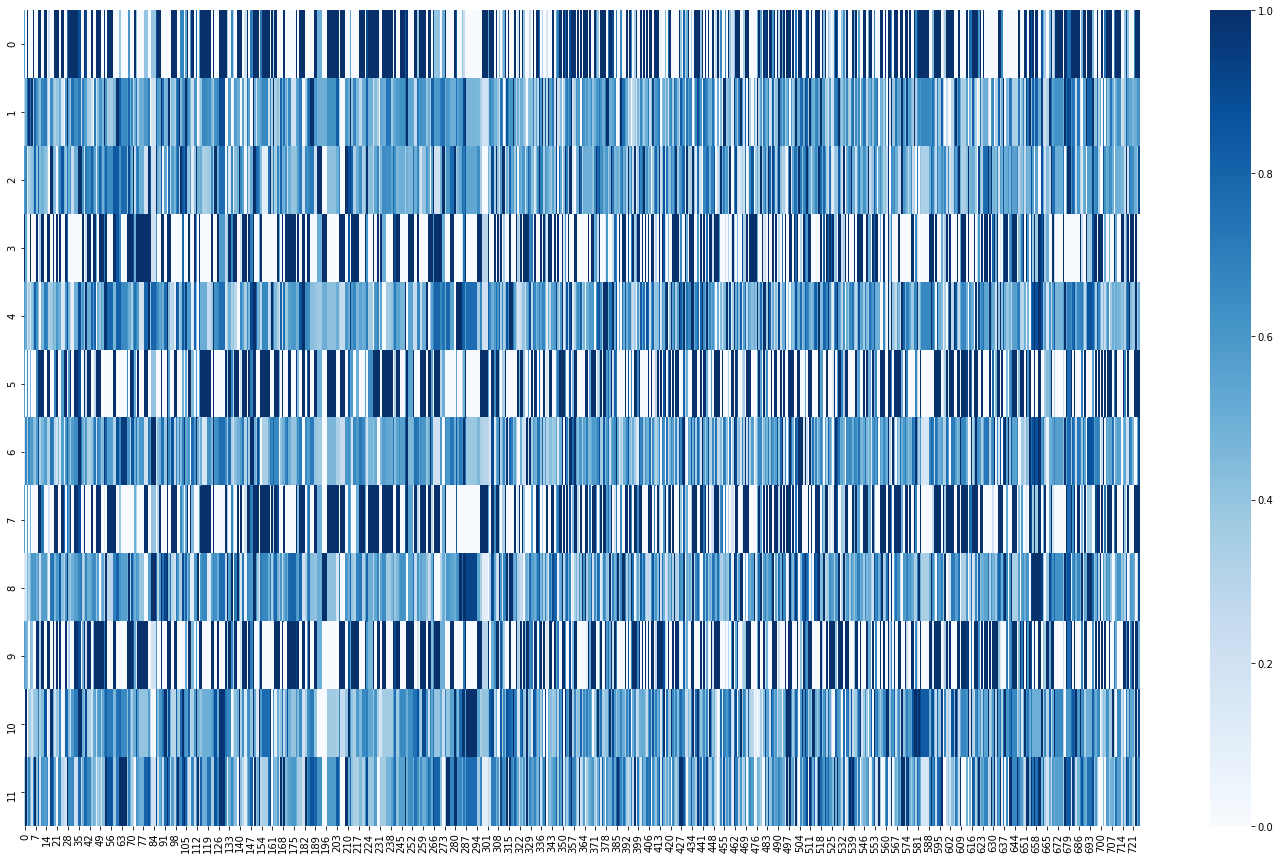

In [35]:
plt.figure(figsize=(25, 15))
sns.heatmap(normalized, cmap='Blues')

# BiClustering the data

In [40]:


# run biclustering on that
biclustering = Biclustering.spectral_biclustering(n_clusters=(3,3),random_state=4)
biclustering.fit(normalized)


# copy back column and row indexes
normalized['Cluster'] = list(map(lambda x:  str(x[1]) ,zip(d.data.index ,  biclustering.model.row_labels_)))
normalized['Sample'] = list(map(lambda x: x[0] ,zip(d.data.index ,  biclustering.model.row_labels_)))
normalized.set_index(['Cluster','Sample'],  inplace=True)
normalized.columns = pd.MultiIndex.from_tuples(list(map(lambda x: (x[0],x[1][1]), 
                                                        zip(biclustering.model.column_labels_,
                                                            d.data.columns.values))))

# normalized.columns = pd.MultiIndex.from_tuples(list(map(lambda x: (x[0],'') ,zip(aaa.model.column_labels_,d.data.columns.values))))


# normalized = normalized.iloc[np.argsort(aaa.model.row_labels_),np.argsort(aaa.model.column_labels_)]

normalized.sort_index(axis=0,inplace=True)

normalized.sort_index(axis=1,inplace=True)

# normalized.sort_index(axis=1)


# print the normalized data
# normalized

In [42]:
from collections import Counter
import numpy as np
print(len(d.data.columns))
# print(len(biclustering.model.biclusters_))
# print(len(biclustering.model.biclusters_[0]))
# print(len(biclustering.model.biclusters_[1]))
print(Counter(biclustering.model.column_labels_))
print(Counter(biclustering.model.row_labels_))
# print(np.argsort(aaa.model.column_labels_))
# print(len(np.argsort(aaa.model.column_labels_)))
# print(len(np.argsort(aaa.model.column_labels_)))

726
Counter({1: 266, 0: 232, 2: 228})
Counter({1: 7, 2: 3, 0: 2})


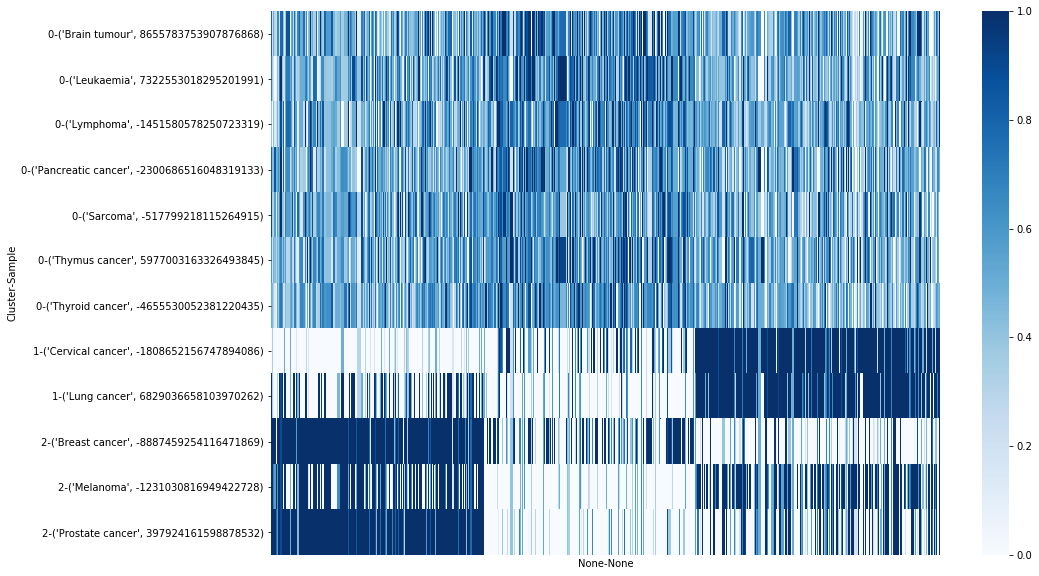

In [38]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(15, 10))
sns.heatmap(normalized, cmap="Blues", robust=True, xticklabels=False)

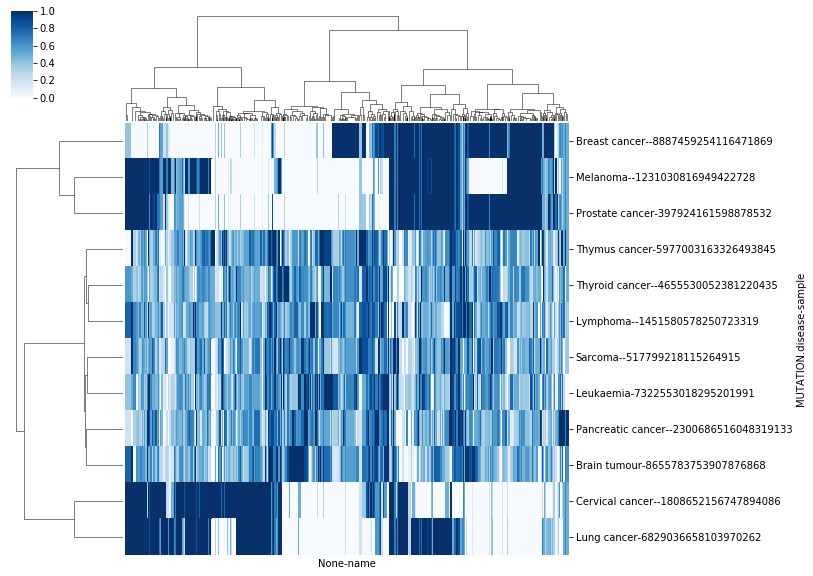

In [39]:
plt.figure(figsize=(15, 10))

sns.clustermap(d.data, method="ward", cmap="Blues",  
               standard_scale=1, row_cluster=True, xticklabels=False)